<a href="https://colab.research.google.com/github/sciencelee/mod4-xray-pneumonia-ML/blob/main/mod4_xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive 
These blocks mount the users google drive.  The chest xrays are stored in the path location of the drive.

In [2]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
import datetime
import os
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

'''
chest_xray  
  └───NORMAL_ALL (contains all normal imgs)
  └───PNEUMONIA_ALL (contains all pneumonia imgs)
  └───train 
  │   └───NORMAL
  │   └───PNEUMONIA
  └───test
  │   └───NORMAL
  │   └───PNEUMONIA
  └───val
      └───NORMAL
      └───PNEUMONIA
'''
pass


In [4]:
path = '/content/drive/MyDrive/chest_xray'
all_normal_folder = path + '/NORMAL_ALL/'
all_pneumonia_folder = path + '/PNEUMONIA_ALL/'

test_folder = path + '/test/'
train_folder = path + '/train/'
val_folder = path + '/val/'

## Building our Train, Test, and Validation Datasets
We will make lists of all of the image names for NORMAL and PNEUMONIA chest xrays.  Then we can divy up the images into individual folders for later use.

I will also use this opportunity to randomize the images, and select the size of the dataset to use.  I will start with a small sets prior to building the final model.

We have two folders.  One for normal images, and one for pnemonia xray images

In [5]:
from random import shuffle, seed
seed(123)

# Make a list of all normal images
normal_imgs = [file for file in os.listdir(all_normal_folder)]
shuffle(normal_imgs) # random lib method for iterables
normal_imgs[:10]

print('There are {} normal xray images.'.format(len(normal_imgs)))


# make a list of all pneumonia images
pneumonia_imgs = [file for file in os.listdir(all_pneumonia_folder)]
shuffle(pneumonia_imgs)
pneumonia_imgs[:10]

all_imgs = normal_imgs + pneumonia_imgs
shuffle(all_imgs)

print('There are {} pneumonia xray images.'.format(len(pneumonia_imgs)))


There are 1583 normal xray images.
There are 4274 pneumonia xray images.


In [6]:
import shutil
# https://docs.python.org/3/library/shutil.html#shutil

# set distribution of datasets
train_test_val = [0.8, 0.1, 0.1] # must add to 1.0

# What percentage of the dataset are we using
size_dataset = 0.4 # what percentage of dataset are we using?

# NORMAL data indices
# indices for train, test, val
n_images_norm = int(round(len(normal_imgs) * size_dataset))

print(
'''
Percent of images used: {:.0%}. (to speed up model iterations)
Train//Test//Val Split: {:.0%}, {:.0%}, {:.0%}
'''.format(size_dataset, train_test_val[0], train_test_val[1], train_test_val[2]))

# get the correct indices to chop up my NORMAL images from a shuffled list
norm_train_index = int(round(n_images_norm * train_test_val[0]))
norm_test_index = int(norm_train_index + round(n_images_norm * train_test_val[1]))
norm_val_index = min(norm_test_index + int(round(n_images_norm * train_test_val[2])), n_images_norm-1)

print('NORMAL xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_norm, norm_train_index, norm_test_index, norm_val_index)) 

# PNEUMONIA data indices
# indices for train, test, val
n_images_pneu = int(round(len(pneumonia_imgs) * size_dataset))

# get the correct indices to chop up my PNEUMONIA images from a shuffled list
pneu_train_index = int(round(n_images_pneu * train_test_val[0]))
pneu_test_index = int(pneu_train_index + round(n_images_pneu * train_test_val[1]))
pneu_val_index = min(pneu_test_index + int(round(n_images_pneu * train_test_val[2])), n_images_pneu-1)


print('\nPNEUMONIA xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_pneu, pneu_train_index, pneu_test_index, pneu_val_index)) 


Percent of images used: 40%. (to speed up model iterations)
Train//Test//Val Split: 80%, 10%, 10%

NORMAL xrays
Total images: 633
Indices: 506, 569, 632

PNEUMONIA xrays
Total images: 1710
Indices: 1368, 1539, 1709


Now that we have all of the names of images in a list, and we have the indices for the split, we will copy image files into the appropriate folders so we can use 'flow_from_directory' method in ImageDataGenerator.

This may take a while.  This is definitely not something I would try on a larger dataset, but it works for this size and gives us some flexibility in training the model.

In [ ]:
# ONLY RUN THIS CELL IF YOU WANT TO RECREATE THE DATASET
# ⏰ ⏰
input("Are you sure you want to continue?")

# empty all of the folders first
shutil.rmtree(test_folder, ignore_errors=True)
shutil.rmtree(train_folder, ignore_errors=True)
shutil.rmtree(val_folder, ignore_errors=True)

os.mkdir(test_folder)
os.mkdir(test_folder + 'NORMAL')
os.mkdir(test_folder + 'PNEUMONIA')
os.mkdir(train_folder)
os.mkdir(train_folder + 'NORMAL')
os.mkdir(train_folder + 'PNEUMONIA')
os.mkdir(val_folder)
os.mkdir(val_folder + 'NORMAL')
os.mkdir(val_folder + 'PNEUMONIA')

# fill them back up with selected images

# NORMAL images first
for image in normal_imgs[:norm_train_index]:
  shutil.copyfile(all_normal_folder + image, train_folder + 'NORMAL/' + image)
else:
  print(train_folder + 'NORMAL')

for image in normal_imgs[norm_train_index:norm_test_index]:
  shutil.copyfile(all_normal_folder + image, test_folder + 'NORMAL/' + image)
else:
  print(test_folder + 'NORMAL')

for image in normal_imgs[norm_test_index:norm_val_index]:
  shutil.copyfile(all_normal_folder + image, val_folder + 'NORMAL/' + image)
else:
  print(val_folder + 'NORMAL')

# PNEUMONIA images
for image in pneumonia_imgs[:pneu_train_index]:
  shutil.copyfile(all_pneumonia_folder + image, train_folder + 'PNEUMONIA/' + image)
else:
  print(train_folder + 'PNEUMONIA')

for image in pneumonia_imgs[pneu_train_index:pneu_test_index]:
  shutil.copyfile(all_pneumonia_folder + image, test_folder + 'PNEUMONIA/' + image)
else:
  print(test_folder + 'PNEUMONIA')

for image in pneumonia_imgs[pneu_test_index:pneu_val_index]:
    shutil.copyfile(all_pneumonia_folder + image, val_folder + 'PNEUMONIA/' + image)
else:
  print(val_folder + 'PNEUMONIA')

Are you sure you want to continue?y
/content/drive/MyDrive/chest_xray/train/NORMAL
/content/drive/MyDrive/chest_xray/test/NORMAL
/content/drive/MyDrive/chest_xray/val/NORMAL
/content/drive/MyDrive/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/chest_xray/val/PNEUMONIA


1530x1716 image. Single color channel.
Max pixel value: 255
Min pixel value: 0
Mean value: 117.37
Std Dev: 64.38


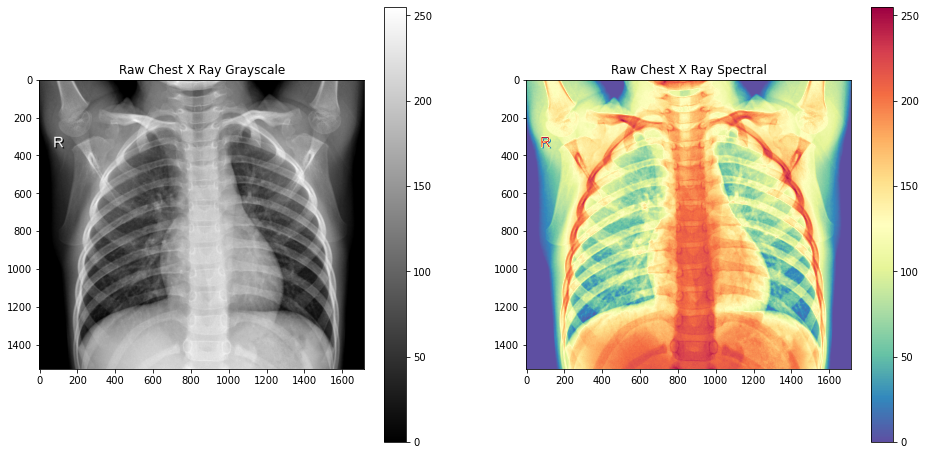

In [8]:
# Original image investigation
filename = all_normal_folder + os.listdir(all_normal_folder)[337]
sample_img = plt.imread(filename)

plt.figure(figsize=[16,8])
plt.subplot(121) 
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Grayscale')

plt.subplot(122) 
plt.imshow(sample_img, cmap='Spectral_r')
plt.colorbar()
plt.title('Raw Chest X Ray Spectral')

print("{}x{} image. Single color channel.".format(sample_img.shape[0], sample_img.shape[1]))
print('Max pixel value: {}\nMin pixel value: {}'.format(sample_img.max(), sample_img.min()))
print('Mean value: {:.2f}\nStd Dev: {:.2f}'.format(sample_img.mean(), sample_img.std()))

In [12]:
# get all the data in the directory and reshape them

n = len(os.listdir(test_folder + 'PNEUMONIA')) + len(os.listdir(test_folder + 'NORMAL'))
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(150, 150),
        batch_size=n
        ) 

n = len(os.listdir(val_folder + 'PNEUMONIA')) + len(os.listdir(val_folder + 'NORMAL'))
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(150, 150),
        batch_size=n
        )

n = len(os.listdir(train_folder + 'PNEUMONIA')) + len(os.listdir(train_folder + 'NORMAL'))
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(150, 150),
        batch_size=n
        )


##### 
# I WANT TO SWITCH THIS TO MAYBE AN 80/10/10 ratio in the folders

Found 234 images belonging to 2 classes.
Found 233 images belonging to 2 classes.
Found 1874 images belonging to 2 classes.


In [14]:
# create the data sets. 
# ⏰ 
test_images, test_labels = next(test_generator)
print('Test')
val_images, val_labels = next(val_generator)
print('Val')
train_images, train_labels = next(train_generator)
print('Train')



Test
Val
Train


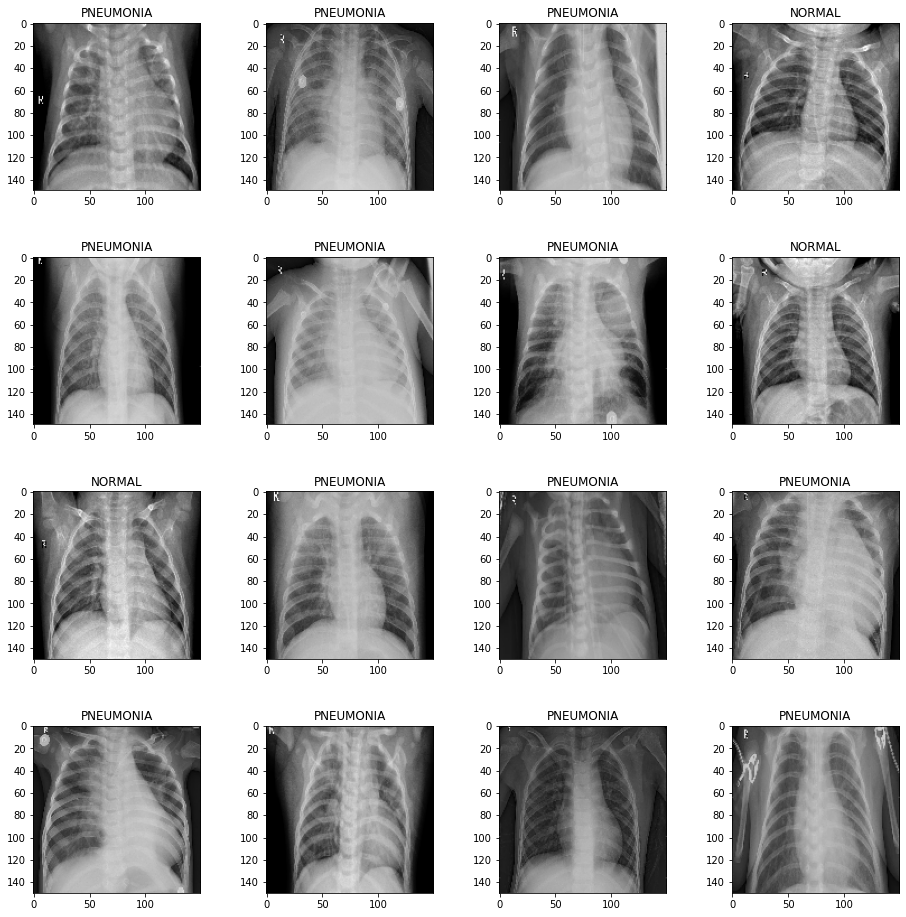

In [15]:
# LITTLE EDA ON DOWNSAMPLED PICS

%matplotlib inline
from keras.preprocessing import image
import matplotlib.pyplot as plt



plt.figure(figsize=(16,16))  # change the size of figure!

for i in range(16):
    img = train_images[i]
    image_label = 'NORMAL' if train_labels[i][1] == 0 else 'PNEUMONIA'

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    #plt.xticks(np.arange(0, 1.5, 0.5))
    #plt.yticks(np.arange(0, 13, 6.0))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(image_label)  # Plot title here!!!

plt.show()

In [16]:
# This block grabs some basic stats for all downsampled images

norm_stats = [0, 0, 0] #norm_mean, norm_std
n_norm = 0

pneu_stats = [0, 0, 0] # , pneu_mean_pneu_std
n_pneu = 0

for i in range(len(train_images)):
  my_img = train_images[i]

  if train_labels[i][1] == 0:
    n_norm += 1
    norm_stats[0] += np.mean(my_img)
    norm_stats[1] += np.std(my_img)
    norm_stats[2] += np.count_nonzero(my_img == 0)

  else:
    n_pneu += 1
    pneu_stats[0] += np.mean(my_img)
    pneu_stats[1] += np.std(my_img)
    pneu_stats[2] += np.count_nonzero(my_img == 0)
  
print("Normal", np.array(norm_stats) / n_norm)
print("Pneumonia", np.array(pneu_stats) / n_pneu)


Normal [4.78533854e-01 2.39480133e-01 5.17217787e+03]
Pneumonia [4.80501770e-01 2.17452348e-01 2.67924342e+03]


In [17]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 1874
Number of testing samples: 234
Number of validation samples: 233
train_images shape: (1874, 150, 150, 3)
train_labels shape: (1874, 2)
test_images shape: (234, 150, 150, 3)
test_labels shape: (234, 2)
val_images shape: (233, 150, 150, 3)
val_labels shape: (233, 2)


In [18]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(1874, 67500)
(234, 67500)
(233, 67500)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


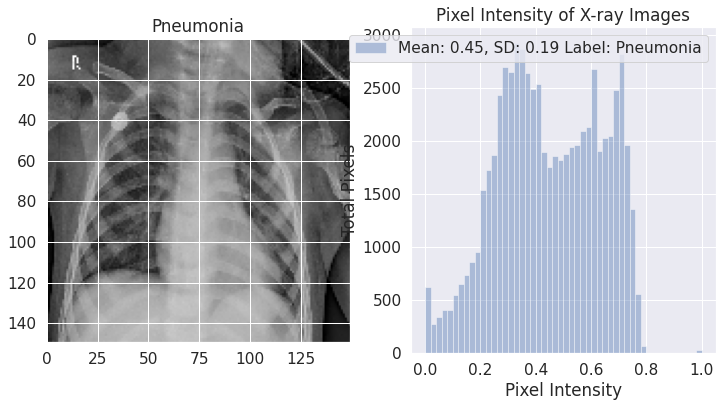

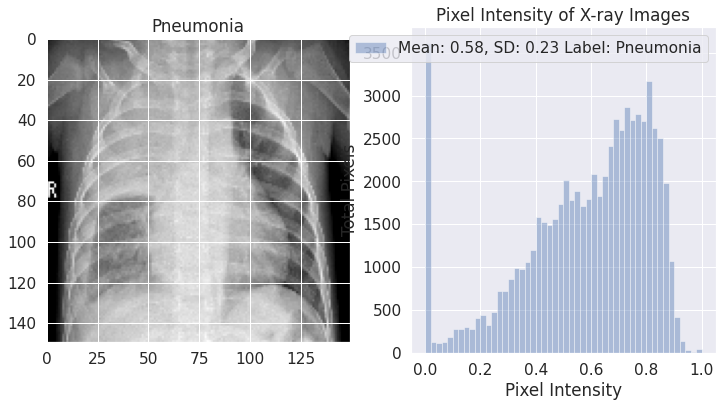

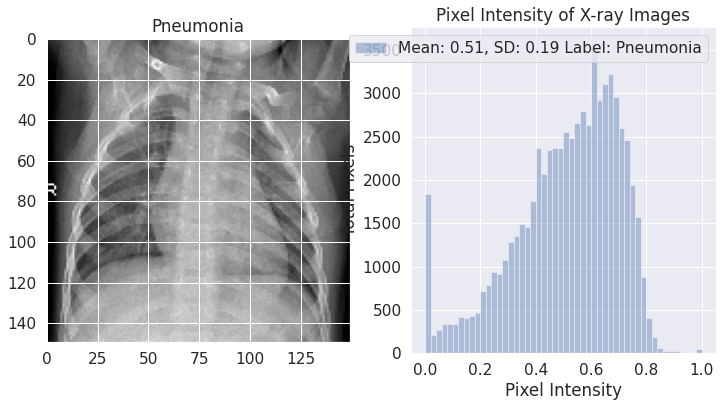

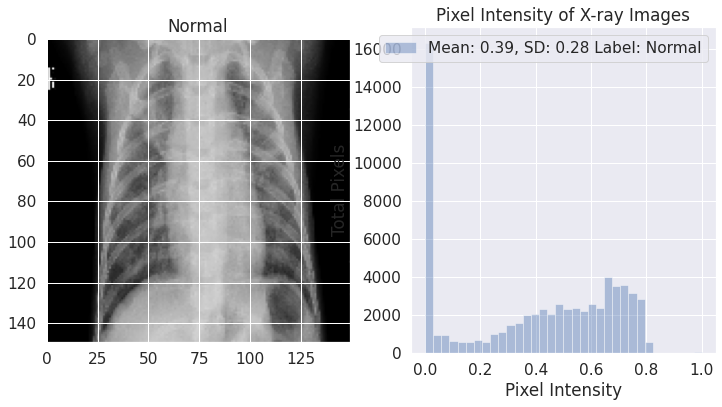

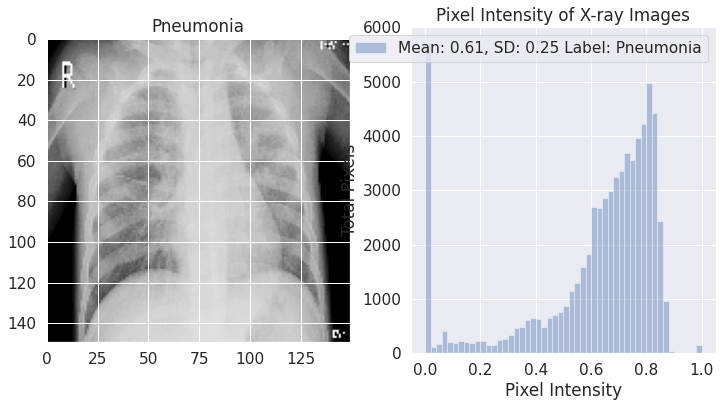

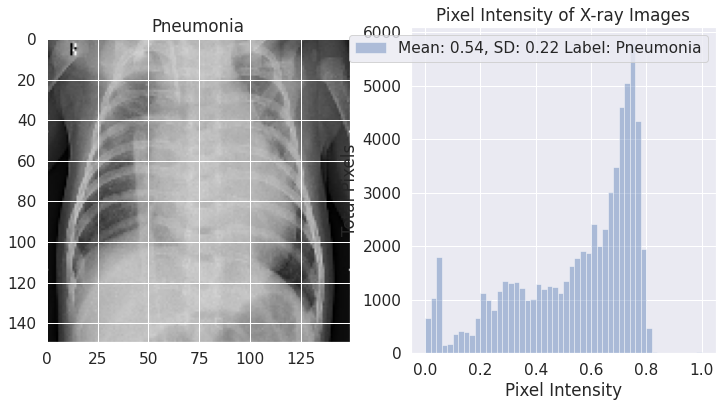

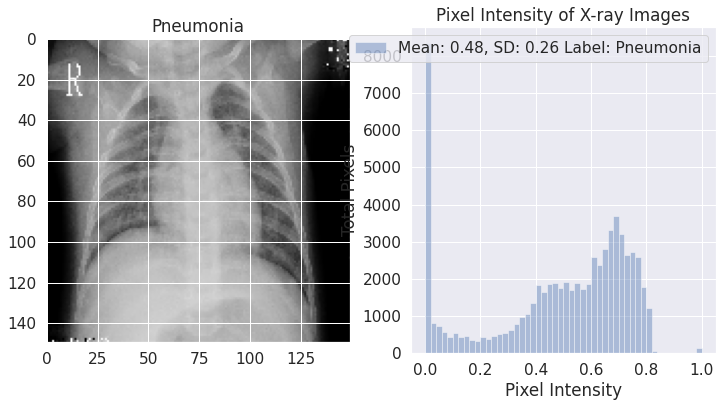

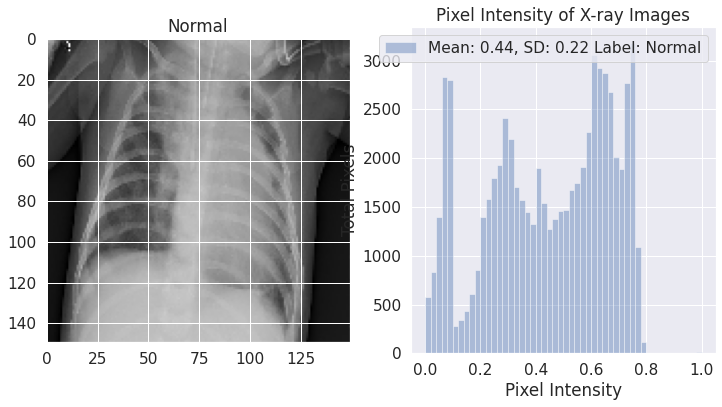

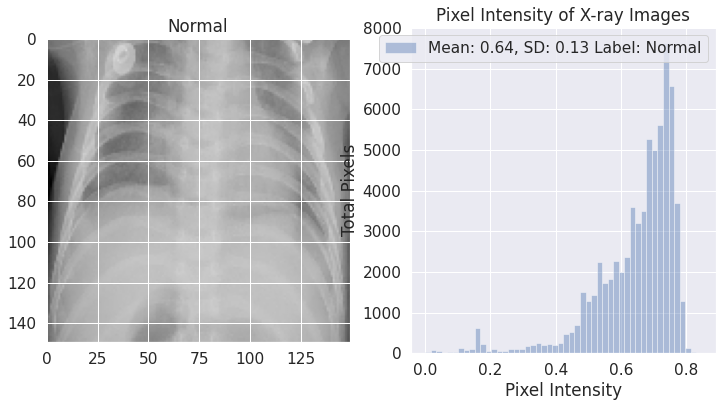

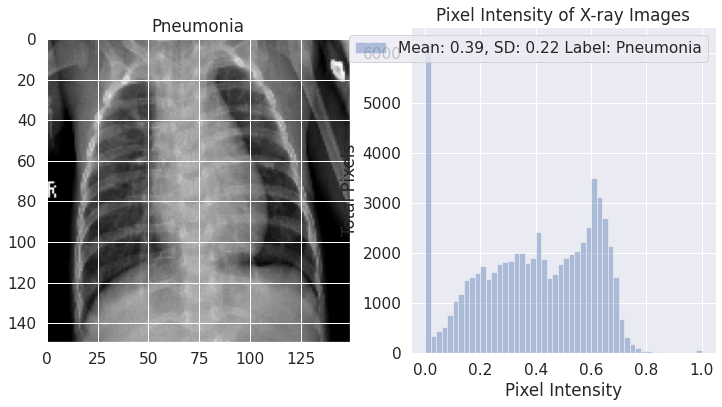

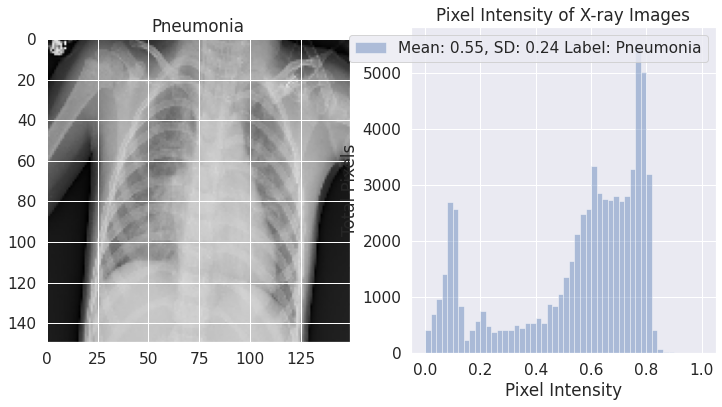

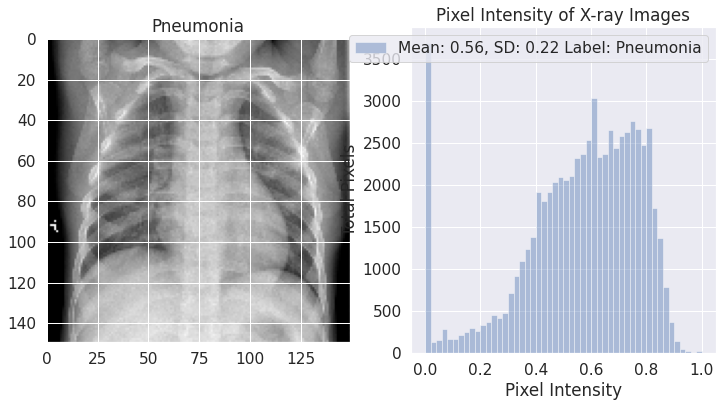

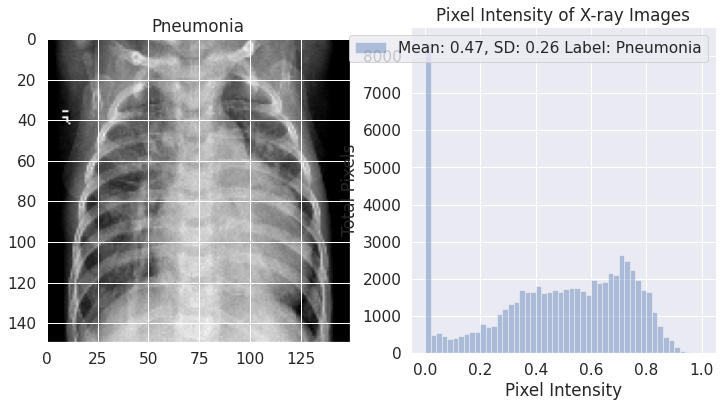

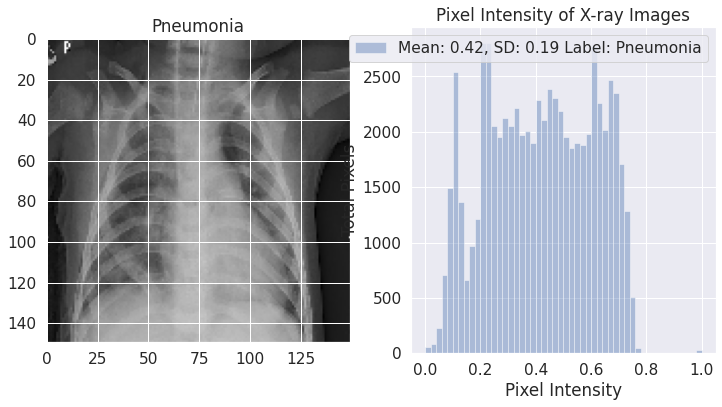

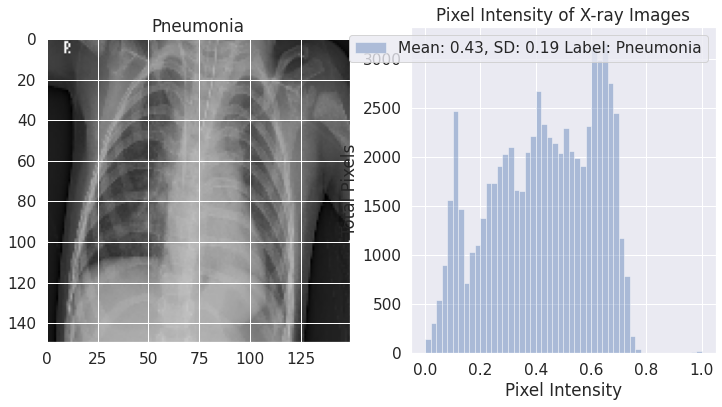

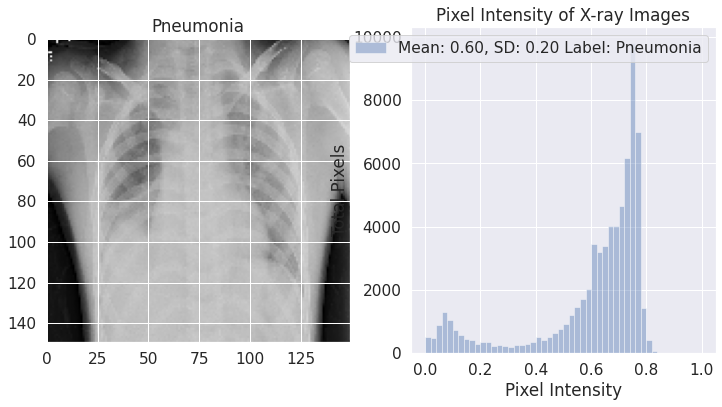

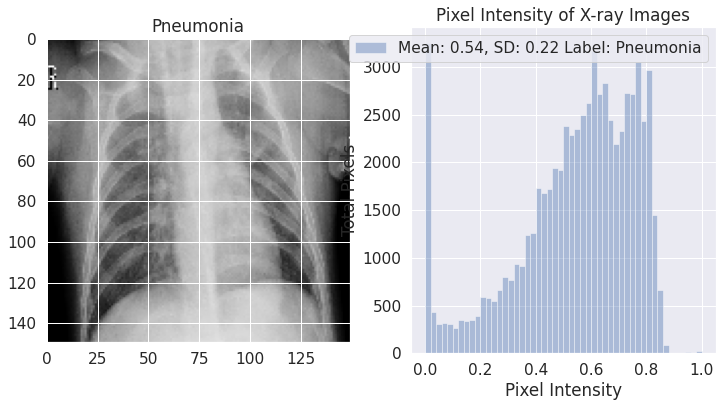

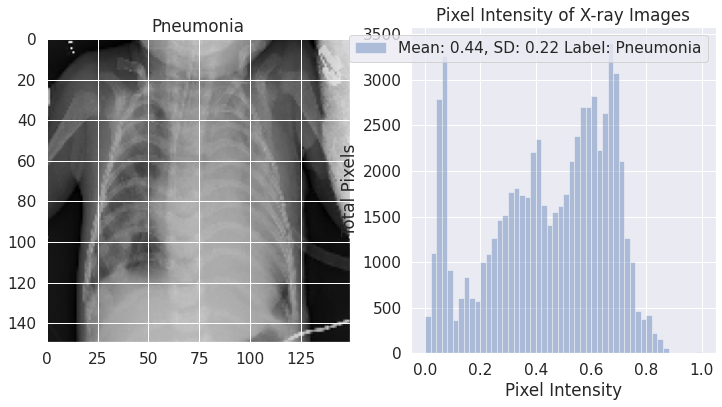

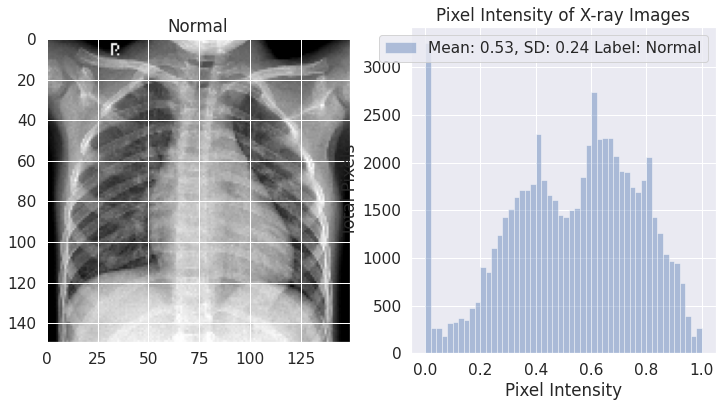

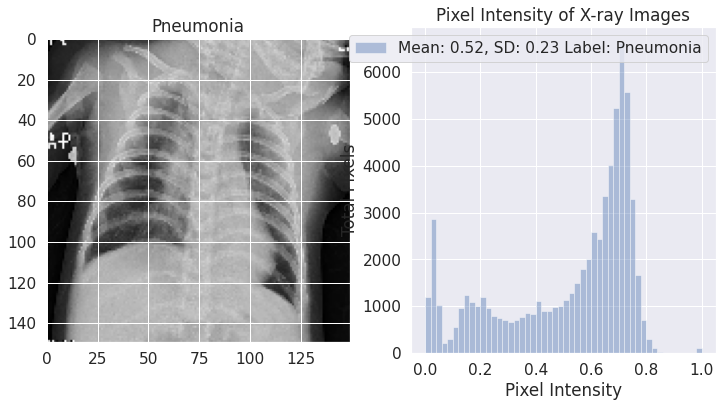

In [89]:
import seaborn as sns

for i in range(20):
  plt.figure(figsize=(12,6))  # change the size of figure!
  plt.subplot(121)
  my_img = test_images[i]
  classification = 'Normal' if train_labels[i][1]==0 else 'Pneumonia'

  plt.imshow(my_img)
  plt.title(classification)
  classification = 'Normal' if train_labels[i][1]==0 else 'Pneumonia'
  label = "Mean: {:.2f}, SD: {:.2f} Label: {}".format(np.mean(my_img), np.std(my_img), classification)
  
  plt.subplot(122)
  sns.distplot(my_img,
              label=label,
              kde=False)
  plt.legend()
  plt.title('Pixel Intensity of X-ray Images')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Total Pixels')
  plt.show()



In [20]:
train_y = np.reshape(train_labels[:,0], (train_img.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_img.shape[0],1))

In [21]:
# Build a baseline fully connected model
from keras import models
from keras import layers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [116]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=20,
                    steps_per_epoch=100,
                    validation_data=(val_img, val_y))

Epoch 1/50
100/100 [==============================] - 2s 15ms/step - loss: 0.1705 - accuracy: 0.9298 - val_loss: 0.2075 - val_accuracy: 0.9356
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 0.1330 - accuracy: 0.9488 - val_loss: 0.1525 - val_accuracy: 0.9485
Epoch 3/50
100/100 [==============================] - 1s 14ms/step - loss: 0.1442 - accuracy: 0.9423 - val_loss: 0.2226 - val_accuracy: 0.9227
Epoch 4/50
100/100 [==============================] - 1s 14ms/step - loss: 0.1377 - accuracy: 0.9453 - val_loss: 0.2373 - val_accuracy: 0.9142
Epoch 5/50
100/100 [==============================] - 1s 14ms/step - loss: 0.1224 - accuracy: 0.9504 - val_loss: 0.1480 - val_accuracy: 0.9356
Epoch 6/50
100/100 [==============================] - 1s 15ms/step - loss: 0.1454 - accuracy: 0.9468 - val_loss: 0.1776 - val_accuracy: 0.9356
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 0.1465 - accuracy: 0.9428 - val_loss: 0.1606 - val_accuracy: 0.9313

That's a pretty good first result I think.  93-94% accuracy.  Test is over 90%



In [23]:
results_train = model.evaluate(train_img, train_y)
results_train

results_test = model.evaluate(test_img, test_y)
results_test

8/8 [==============================] - 0s 5ms/step - loss: 0.1748 - accuracy: 0.9188


[0.1747608631849289, 0.9188033938407898]

## Build the CNN

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')



Found 1874 images belonging to 2 classes.
Found 233 images belonging to 2 classes.


In [ ]:
from keras import layers
from keras import models

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from keras import optimizers

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#Training and evaluation

In [ ]:
# ⏰ This cell may take several minutes to run
history2 = model2.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              validation_steps=20)

Epoch 1/20
50/50 [==============================] - 52s 1s/step - loss: 0.2690 - acc: 0.8863
Epoch 2/20
50/50 [==============================] - 52s 1s/step - loss: 0.2220 - acc: 0.9024
Epoch 3/20
50/50 [==============================] - 54s 1s/step - loss: 0.1962 - acc: 0.9145
Epoch 4/20
50/50 [==============================] - 52s 1s/step - loss: 0.1707 - acc: 0.9390
Epoch 5/20
50/50 [==============================] - 52s 1s/step - loss: 0.1692 - acc: 0.9316
Epoch 6/20
50/50 [==============================] - 52s 1s/step - loss: 0.1604 - acc: 0.9400
Epoch 7/20
50/50 [==============================] - 52s 1s/step - loss: 0.1373 - acc: 0.9477
Epoch 8/20
50/50 [==============================] - 52s 1s/step - loss: 0.1412 - acc: 0.9450
Epoch 9/20
50/50 [==============================] - 52s 1s/step - loss: 0.1339 - acc: 0.9470
Epoch 10/20
50/50 [==============================] - 52s 1s/step - loss: 0.1440 - acc: 0.9447
Epoch 11/20
50/50 [==============================] - 52s 1s/step - lo

In [ ]:
history2.history

{'acc': [0.8863179087638855,
  0.9024145007133484,
  0.9144869446754456,
  0.9390000104904175,
  0.9315895438194275,
  0.9399999976158142,
  0.9476861357688904,
  0.9449999928474426,
  0.9470000267028809,
  0.9446679949760437,
  0.949999988079071,
  0.9507042169570923,
  0.9486921429634094,
  0.9580000042915344,
  0.9649999737739563,
  0.9567404389381409,
  0.9647887349128723,
  0.9599999785423279,
  0.968812882900238,
  0.968999981880188],
 'loss': [0.26900139451026917,
  0.22198349237442017,
  0.19621245563030243,
  0.17067980766296387,
  0.16919320821762085,
  0.16040924191474915,
  0.13726185262203217,
  0.14122334122657776,
  0.13388510048389435,
  0.1440018266439438,
  0.1267293393611908,
  0.11510766297578812,
  0.11839642375707626,
  0.10649406164884567,
  0.09181804955005646,
  0.11125336587429047,
  0.09108427911996841,
  0.08890698105096817,
  0.07721123844385147,
  0.08441054821014404]}

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

print(history2.history)

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

{'loss': [0.26900139451026917, 0.22198349237442017, 0.19621245563030243, 0.17067980766296387, 0.16919320821762085, 0.16040924191474915, 0.13726185262203217, 0.14122334122657776, 0.13388510048389435, 0.1440018266439438, 0.1267293393611908, 0.11510766297578812, 0.11839642375707626, 0.10649406164884567, 0.09181804955005646, 0.11125336587429047, 0.09108427911996841, 0.08890698105096817, 0.07721123844385147, 0.08441054821014404], 'acc': [0.8863179087638855, 0.9024145007133484, 0.9144869446754456, 0.9390000104904175, 0.9315895438194275, 0.9399999976158142, 0.9476861357688904, 0.9449999928474426, 0.9470000267028809, 0.9446679949760437, 0.949999988079071, 0.9507042169570923, 0.9486921429634094, 0.9580000042915344, 0.9649999737739563, 0.9567404389381409, 0.9647887349128723, 0.9599999785423279, 0.968812882900238, 0.968999981880188]}


KeyError: ignored

The accuracy with just 50% of the dataset is over 96% (training acc).  Let's see how it performs with new data.

In [ ]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:24:38.446406


In [ ]:
model2.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_50_801010.h5')


In [ ]:
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 234 images belonging to 2 classes.
test acc: 0.9150000214576721


In [ ]:
# we can now load the saved model

from keras.models import load_model
model = load_model('/content/drive/MyDrive/chest_xray/chest_xray_cnn_50_801010.h5')

In [ ]:
model.predict()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
# I want to try a dropout strategy.  Not sure if it applies here

model3 = models.Sequential()


model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
#model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
#model3.add(layers.Dropout(0.2))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history3 = model3.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              validation_steps=20)

Epoch 1/20
50/50 [==============================] - 59s 1s/step - loss: 0.5674 - acc: 0.7324 - val_loss: 0.6299 - val_acc: 0.7468
Epoch 2/20
50/50 [==============================] - 54s 1s/step - loss: 0.4624 - acc: 0.8008
Epoch 3/20
50/50 [==============================] - 54s 1s/step - loss: 0.3320 - acc: 0.8520
Epoch 4/20
50/50 [==============================] - 57s 1s/step - loss: 0.2889 - acc: 0.8783
Epoch 5/20
50/50 [==============================] - 54s 1s/step - loss: 0.2567 - acc: 0.8930
Epoch 6/20
50/50 [==============================] - 54s 1s/step - loss: 0.2360 - acc: 0.9095
Epoch 7/20
50/50 [==============================] - 54s 1s/step - loss: 0.2319 - acc: 0.9095
Epoch 8/20
50/50 [==============================] - 54s 1s/step - loss: 0.2046 - acc: 0.9165
Epoch 9/20
50/50 [==============================] - 54s 1s/step - loss: 0.1915 - acc: 0.9240
Epoch 10/20
50/50 [==============================] - 54s 1s/step - loss: 0.1735 - acc: 0.9400
Epoch 11/20
50/50 [=============

In [ ]:
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model3.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 234 images belonging to 2 classes.
test acc: 0.8899999856948853


In [ ]:
model3.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_dropout_40_801010.h5')

Make a quick evaluator for new images

In [90]:
import random
%matplotlib inline
from keras.preprocessing import image
import matplotlib.pyplot as plt

correct = 0
incorrect = 0

print("{:12}{:12}{:12}{:12}".format('Label', 'Prediction', 'Float', 'Correct?'))

# go through some images and predict them individually.
for i in range(len(test_images)):
  img = test_images[i]
  #print(img.shape)
  img = img.reshape(-1, 150,150, 3)

  #print(type(test_labels[i][0]))
  if test_labels[i][1] > 0:
    image_label = 'NORMAL'
  else:
    image_label = 'PNEUMONIA'
  #image_label = 'NORMAL' if test_labels[i][1] == 0 else 'PNEUMONIA'


  result = model2.predict(img)
  pred_float = result[0][0]

  if result[0].round() > 0:
    prediction = 'NORMAL'
  else:
    prediction = 'PNEUMONIA'  
  
  print('{:12}{:12}{:<12.2f}'.format(image_label, prediction, pred_float), end=' ')

  if prediction == image_label:
    correct += 1
    print("\U0001F603") 
  else:
    incorrect += 1
    print(u'\u274C')


  

print(correct / (correct + incorrect))




Label       Prediction  Float       Correct?    


NameError: ignored

In [26]:
print(len(test_images))   


234


In [50]:
# CONFUSION MATRIX AND SCORING
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_img) # Pick the best model
acc = accuracy_score(test_y, np.round(preds))*100
cm = confusion_matrix(test_y, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('Confusion matrix')
print(cm)

print('\nMetrics')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


Confusion matrix
[[169   2]
 [ 29  34]]

Metrics
Accuracy: 86.75213675213675%
Precision: 94.44444444444444%
Recall: 53.96825396825397%
F1-score: 68.68686868686869


In [47]:
hist.history.keys()
#model.predict(train_img) # Pick the best model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Chest X-ray Confusion Matrix')

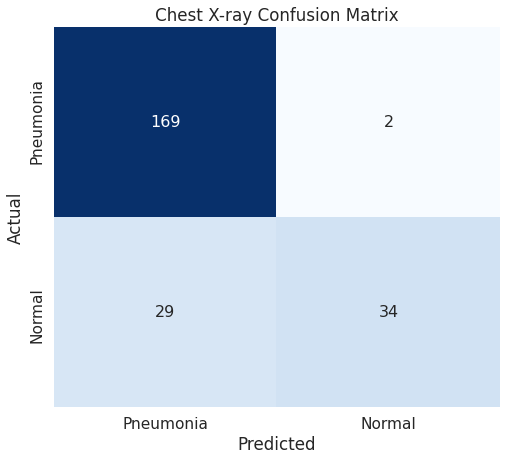

In [92]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

df_cm = pd.DataFrame(cm, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g', cbar=False)# font size
plt.xticks([0.5, 1.5], ['Pneumonia', 'Normal'])
plt.yticks([0.3, 1.4], ['Pneumonia', 'Normal'])
plt.title('Chest X-ray Confusion Matrix')


In [67]:
len(os.listdir(all_normal_folder))

1583

In [68]:
len(os.listdir(all_pneumonia_folder))

4274

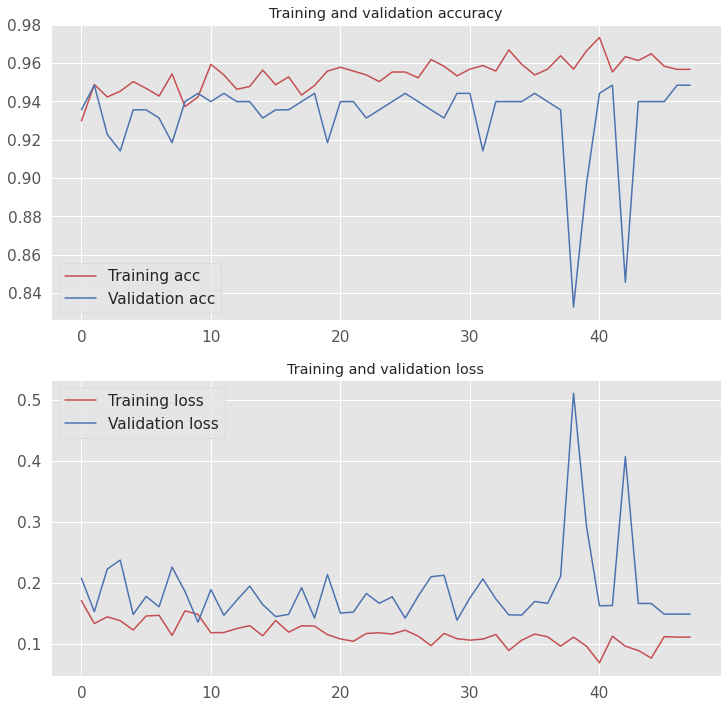

In [119]:


import matplotlib.pyplot as plt
%matplotlib inline 
#print(hist.history.keys())

plt.style.use('ggplot')

plt.figure(figsize=[12,12])
plt.subplot(211)
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()